In [1]:
import json

import numpy as np

from scoring import NoteList, extract_midi_notes


def get_notes(file_path) -> NoteList:
    if file_path.endswith(".midi"):
        return extract_midi_notes(file_path)
    with open(file_path, "rb") as f:
        (note_list := NoteList()).ParseFromString(f.read())
    return note_list


with open("../scores/spider dance aligned.json", "r") as f:
    aligned = json.load(f)

actual = get_notes("../scores/spiderdance_notes.pb")
played = get_notes("../audio/spider dance played.midi")

actual_notes = np.fromiter(actual.notes, dtype=object)
played_notes = np.fromiter(played.notes, dtype=object)

left_tuple, right_tuple = zip(*aligned)
a_aligned, p_aligned = actual_notes[list(left_tuple)], played_notes[list(right_tuple)]

In [2]:
a_times = np.fromiter((a.start_time for a in a_aligned), dtype=np.float32)
p_times = np.fromiter((p.start_time for p in p_aligned), dtype=np.float32)
a_pages = np.fromiter((a.page for a in a_aligned), dtype=np.int32)

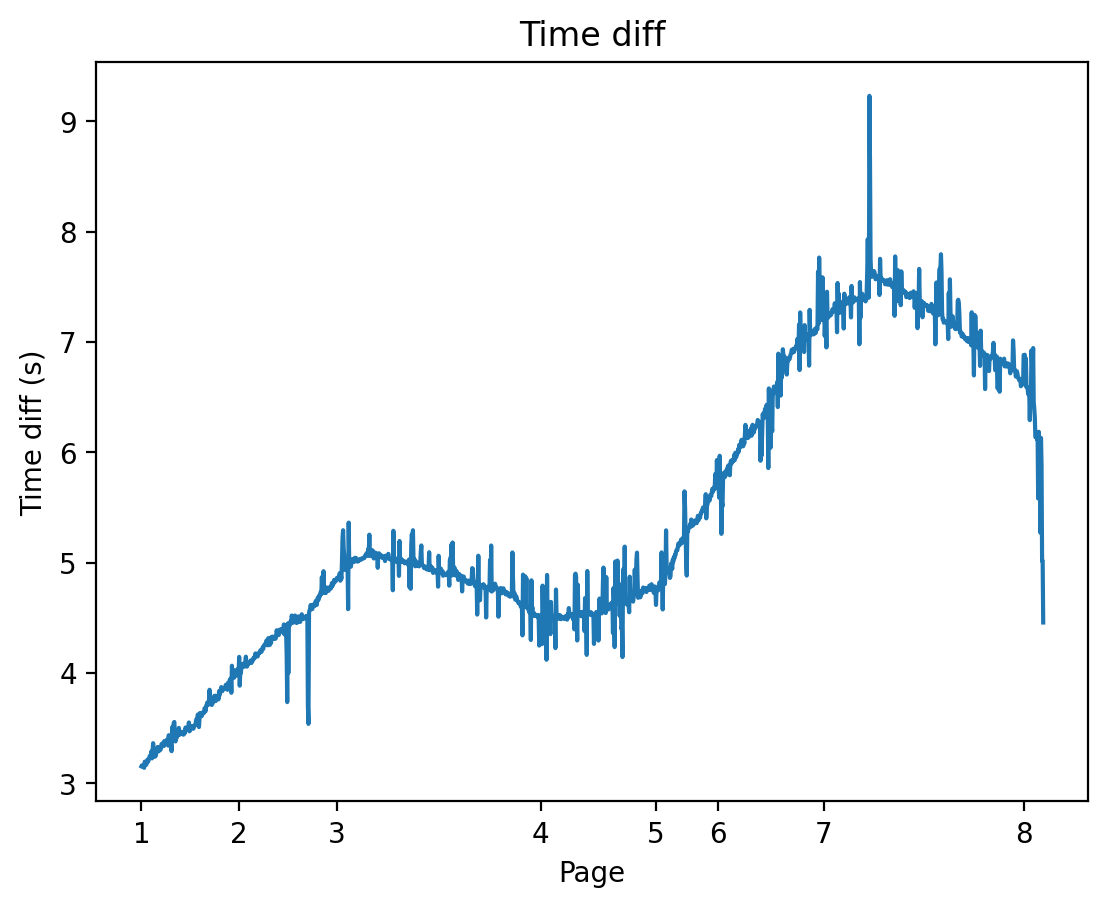

In [3]:
import matplotlib.pyplot as plt

# scores
y = a_times - p_times
x = np.arange(len(y))
unique_pages, first_idx = np.unique(a_pages, return_index=True)

plt.title("Time diff")
plt.xlabel("Page")
plt.ylabel("Time diff (s)")
plt.xticks(first_idx, unique_pages + 1)
plt.plot(x, y)
plt.show()

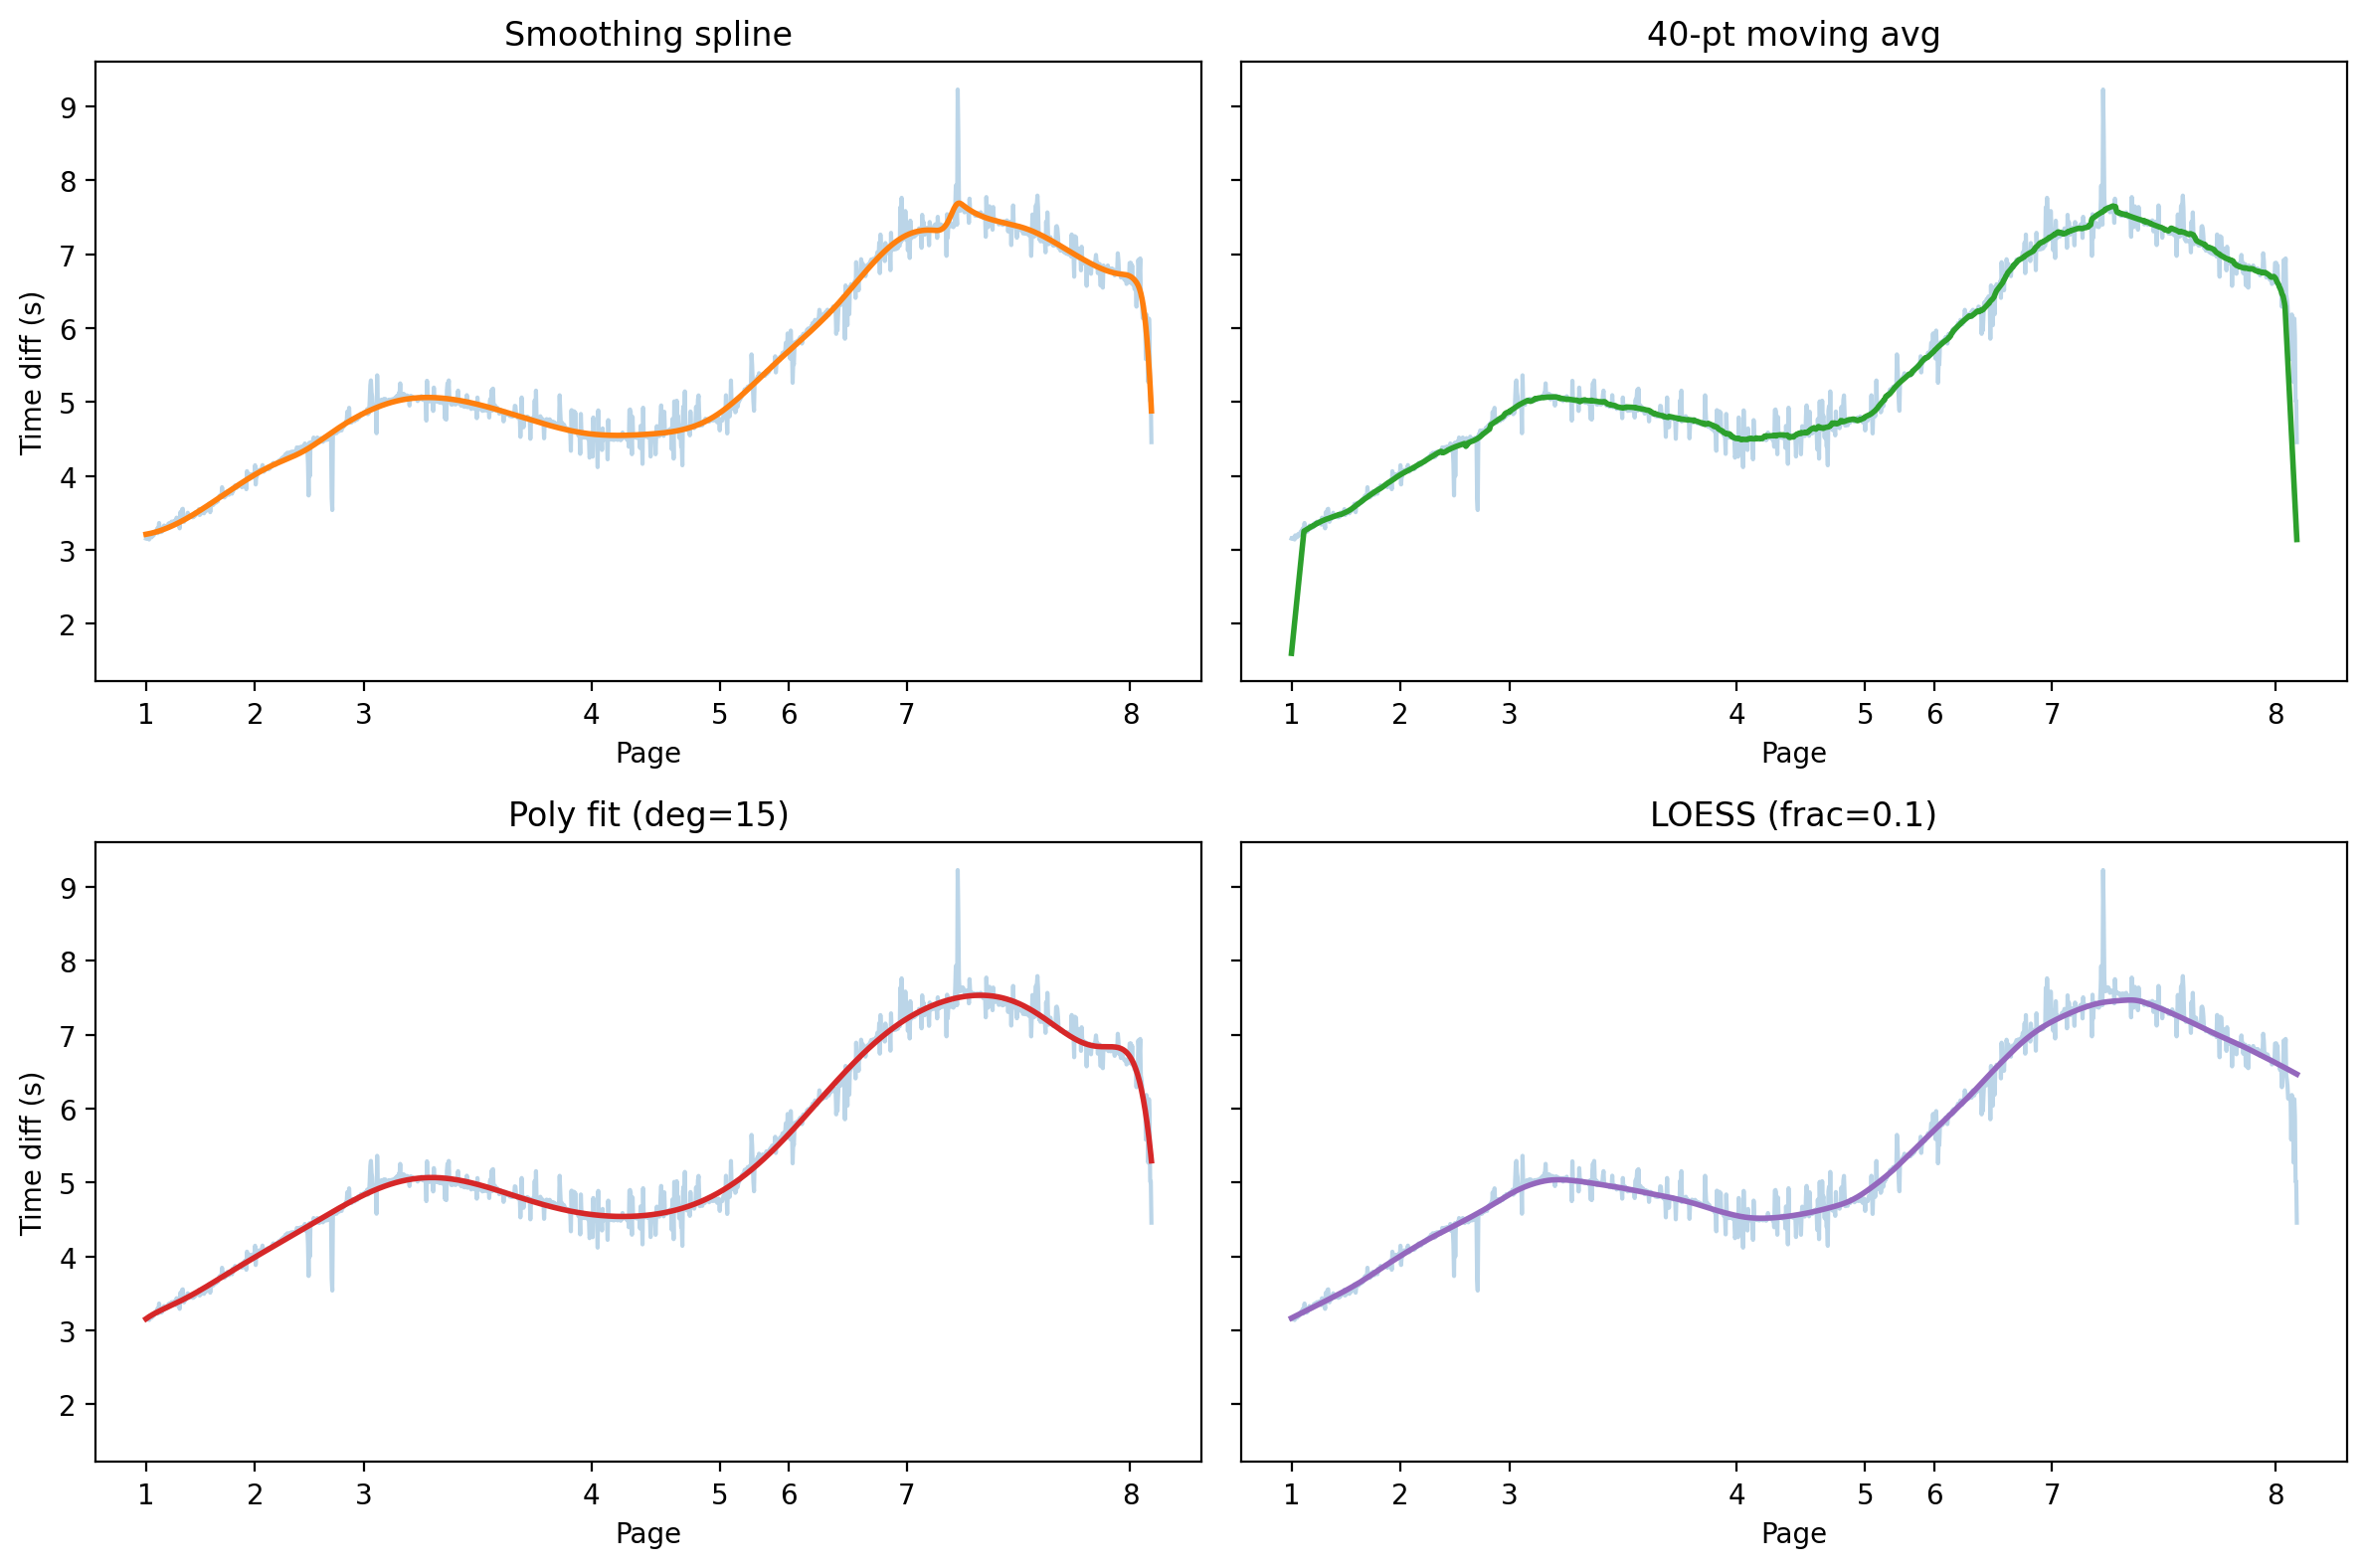

In [4]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm

# 1) smoothing spline
spl = UnivariateSpline(x, y, s=25)
y_smooth = spl(x)

# 2) moving average
window = 40
y_ma = np.convolve(y, np.ones(window) / window, mode="same")

# 3) polynomial fit (degree 3 here)
deg = 15
coeffs = np.polyfit(x, y, deg)
y_poly = np.poly1d(coeffs)(x)

# 4) LOWESS
lowess = sm.nonparametric.lowess
frac = 0.1
z = lowess(y, x, frac=frac)
x_lo, y_lo = z[:, 0], z[:, 1]

# create a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)

# Top-left: smoothing spline
ax = axes[0, 0]
ax.plot(x, y, alpha=0.3, color="C0")
ax.plot(x, y_smooth, lw=2, color="C1")
ax.set_xticks(first_idx)
ax.set_xticklabels(unique_pages + 1)
ax.set_title("Smoothing spline")
ax.set_xlabel("Page")
ax.set_ylabel("Time diff (s)")

# Top-right: moving average
ax = axes[0, 1]
ax.plot(x, y, alpha=0.3, color="C0")
ax.plot(x, y_ma, lw=2, color="C2")
ax.set_xticks(first_idx)
ax.set_xticklabels(unique_pages + 1)
ax.set_title(f"{window}-pt moving avg")
ax.set_xlabel("Page")

# Bottom-left: polynomial fit
ax = axes[1, 0]
ax.plot(x, y, alpha=0.3, color="C0")
ax.plot(x, y_poly, lw=2, color="C3")
ax.set_xticks(first_idx)
ax.set_xticklabels(unique_pages + 1)
ax.set_title(f"Poly fit (deg={deg})")
ax.set_xlabel("Page")
ax.set_ylabel("Time diff (s)")

# Bottom-right: LOESS
ax = axes[1, 1]
ax.plot(x, y, alpha=0.3, color="C0")
ax.plot(x_lo, y_lo, lw=2, color="C4")
ax.set_xticks(first_idx)
ax.set_xticklabels(unique_pages + 1)
ax.set_title(f"LOESS (frac={frac})")
ax.set_xlabel("Page")

plt.tight_layout()
plt.show()

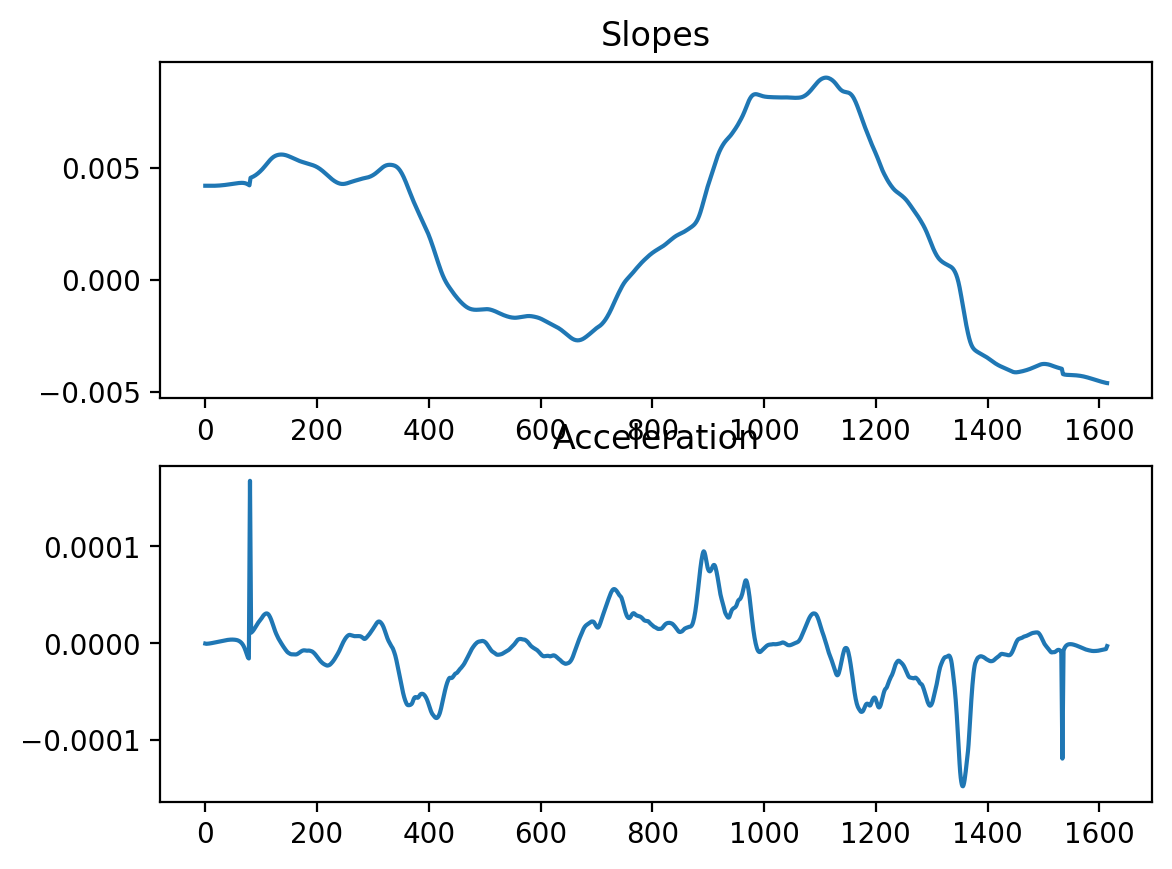

In [5]:
slopes = np.gradient(y_lo)
accel = np.gradient(slopes)
ax = plt.subplot(2, 1, 1)
ax.plot(x_lo, slopes)
ax.set_title("Slopes")
ax = plt.subplot(2, 1, 2)
ax.plot(x_lo, accel)
ax.set_title("Acceleration")
plt.show()

In [6]:
ur = np.std(slopes)
round(ur * 1e5)

409

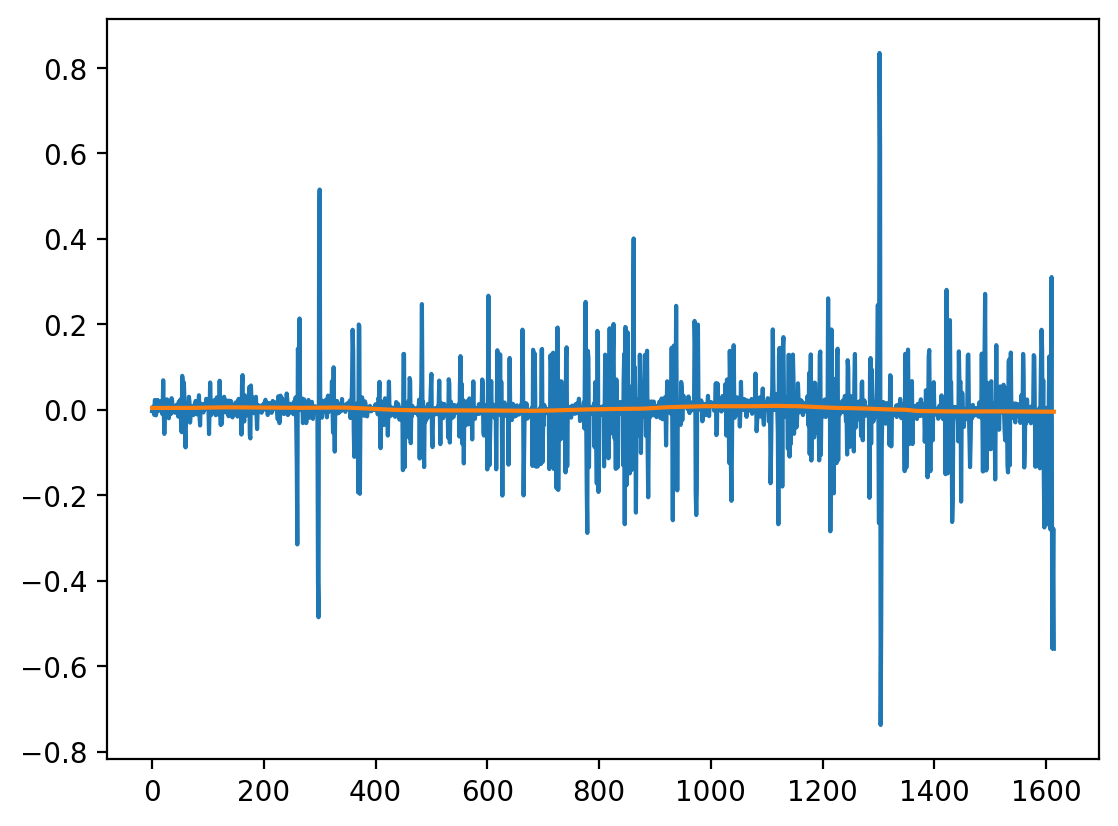

In [7]:
diff_changes = np.gradient(y)
plt.plot(x, diff_changes)
plt.plot(x_lo, slopes)
plt.show()

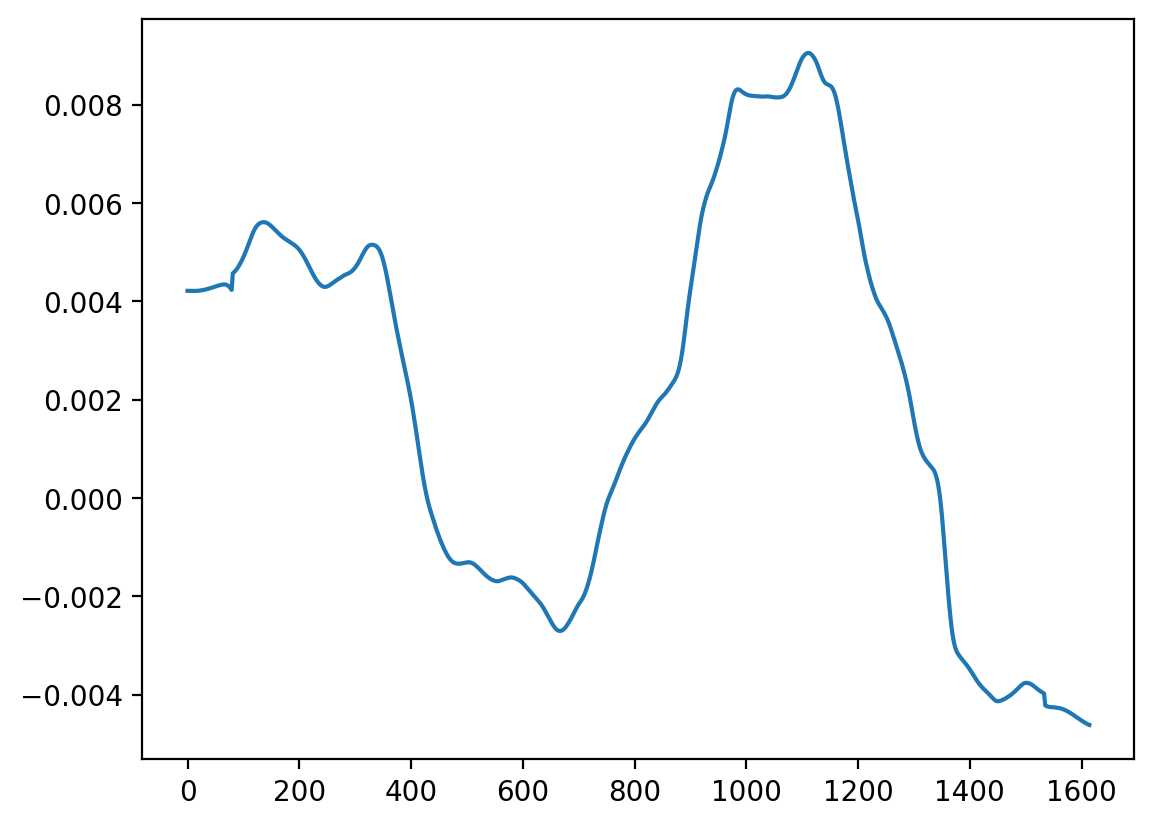

In [8]:
diff_changes = np.gradient(y)
plt.plot(x_lo, slopes)
plt.show()